# Introduction

<center><img src="https://i.imgur.com/9hLRsjZ.jpg" height=400></center>

This dataset was scraped from [nextspaceflight.com](https://nextspaceflight.com/launches/past/?page=1) and includes all the space missions since the beginning of Space Race between the USA and the Soviet Union in 1957!

### Import Statements

In [1]:
# Importing necessary libraries for data manipulation, visualization, and handling warnings
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from iso3166 import countries
from warnings import filterwarnings

filterwarnings("ignore")

### Notebook Presentation

In [2]:
# Setting float display format for better readability of numerical data
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data

In [3]:
# Loading mission launch data, parsing thousands separators for numerical columns
df_data = pd.read_csv('assets/mission_launches.csv', thousands=",")

# Preliminary Data Exploration

* What is the shape of `df_data`? 
* How many rows and columns does it have?
* What are the column names?
* Are there any NaN values or duplicates?

In [4]:
# Initialize an empty report to fill
report = []
# Get shape of dataframe (rows, columns)
n_rows, n_columns = df_data.shape
# Get list of column names
column_names = df_data.columns.to_list()
# Calculate the number of duplicate rows
n_duplicates = df_data.duplicated().sum()
# Count missing values in each column
missingness = df_data.isna().sum()
# Get columns with missing values and their counts
missingness = missingness[missingness > 0].to_dict()

# Filling the report with early calculations
report.append(f"Number of rows: {n_rows}")
report.append(f"Number of columns: {n_columns}")

# Prepare a report of column names
col_report = "Columns:\n"
for col_name in column_names:
    col_report+= f"  - `{col_name}`\n"
report.append(col_report.strip())

# Report the number of duplicates
report.append(f"Number of duplicates: {n_duplicates}")

# Prepare a report on missing values
missingness_report = "Missingness:\n"
for key, value in missingness.items():
    missingness_report += f"  - `{key}`: {value}({value/n_rows:.2%})\n"

# If there are any missing values, append to the report
if missingness:
    report.append(missingness_report.strip())

In [5]:
# Display the exploration report
for i, term in enumerate(report, start=1):
    print(f"{i}- {term}")

1- Number of rows: 4324
2- Number of columns: 9
3- Columns:
  - `Unnamed: 0.1`
  - `Unnamed: 0`
  - `Organisation`
  - `Location`
  - `Date`
  - `Detail`
  - `Rocket_Status`
  - `Price`
  - `Mission_Status`
4- Number of duplicates: 0
5- Missingness:
  - `Price`: 3360(77.71%)


## Data Cleaning - Check for Missing Values and Duplicates

Consider removing columns containing junk data. 

In [6]:
# Display the first 5 rows to inspect the data
df_data.head(5)

Unnamed: 0.1  Unnamed: 0 Organisation  \
0             0           0       SpaceX   
1             1           1         CASC   
2             2           2       SpaceX   
3             3           3    Roscosmos   
4             4           4          ULA   

                                            Location  \
0         LC-39A, Kennedy Space Center, Florida, USA   
1  Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...   
2                      Pad A, Boca Chica, Texas, USA   
3       Site 200/39, Baikonur Cosmodrome, Kazakhstan   
4           SLC-41, Cape Canaveral AFS, Florida, USA   

                         Date                                        Detail  \
0  Fri Aug 07, 2020 05:12 UTC  Falcon 9 Block 5 | Starlink V1 L9 & BlackSky   
1  Thu Aug 06, 2020 04:01 UTC           Long March 2D | Gaofen-9 04 & Q-SAT   
2  Tue Aug 04, 2020 23:57 UTC            Starship Prototype | 150 Meter Hop   
3  Thu Jul 30, 2020 21:25 UTC  Proton-M/Briz-M | Ekspress-80 & Ekspress-103   
4  Thu Jul 30, 2020 11:50 UTC                    Atlas V 541 | Perseverance   

  Rocket_Status  Price Mission_Status  
0  StatusActive  50.00        Success  
1  StatusActive  29.75        Success  
2  StatusActive    NaN        Success  
3  StatusActive  65.00        Success  
4  StatusActive 145.00        Success

In [7]:
# Check for duplicate index columns
is_duplicate_index  = np.equal(df_data.iloc[:, 0], df_data.iloc[:, 1]).all()\
                  and np.equal(df_data.iloc[:, 0], df_data.index).all()

if is_duplicate_index:
    # Drop redundant columns
    df_data.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1, inplace=True)

In [8]:
# Rename columns to lowercase for consistency
df_data.columns = df_data.columns.str.lower()

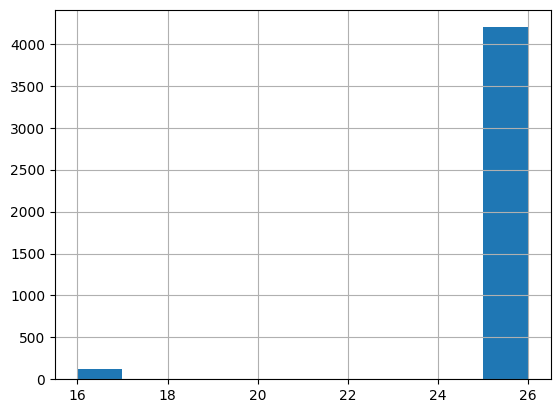

In [9]:
# Visualize the length of the 'date' strings to check for inconsistencies
date_str_length = df_data["date"].str.len()
date_str_length.hist()
plt.show()

In [10]:
# Sample rows with specific date lengths to investigate formats
for value in sorted(date_str_length.unique()):
    display(df_data[df_data["date"].str.len() == value].sample(random_state=42))

organisation                                    location  \
2556    RVSN USSR  Site 31/6, Baikonur Cosmodrome, Kazakhstan   

                  date                                detail  rocket_status  \
2556  Mon Oct 30, 1978  Molniya-M /Block SO-L | Prognoz n†­7  StatusRetired   

      price mission_status  
2556    NaN        Success

organisation                                   location  \
2773    RVSN USSR  Site 1/5, Baikonur Cosmodrome, Kazakhstan   

                            date            detail  rocket_status  price  \
2773  Thu Oct 14, 1976 17:39 UTC  Soyuz | Soyuz 23  StatusRetired    NaN   

     mission_status  
2773        Success

- The `date` column has two formats:
    1. weekday month day of the month, year
    1. weekday month day of the month, year hour:minute UTC

In [11]:
# Manage inconsistency in date formats by padding the shorter format
date = df_data["date"].str.strip().str.replace(r"(\d{4})$", r"\1 00:00 UTC", regex=True)
# Parse the date into a datetime object
date = pd.to_datetime(date, format="%a %b %d, %Y %H:%M UTC")
df_data["date"] = date

In [12]:
# Create period series for years and months
df_data = df_data.assign(year=date.dt.to_period("Y"), month=date.dt.to_period("M"))

In [13]:
# Check for duplicates in the final format of the data
print("Duplicates after removing redundant columns:", df_data.duplicated().sum())

Duplicates after removing redundant columns: 1


- One duplicate was found and will be removed.

In [14]:
# Drop any duplicated records, keeping the first occurrence, and reset the index
df_data = df_data.drop_duplicates(keep="first").reset_index(drop=True)

In [15]:
# Check unique values in status columns
categorical_col = ["rocket_status", "mission_status"]
for col in categorical_col:
    print()
    print(col.center(50,"-"))
    # Print unique values excluding "nan"
    print(*sorted(filter(lambda x: x != "nan", map(str, df_data[col].unique()))), sep=", ")
    print("="*50)


------------------rocket_status-------------------
StatusActive, StatusRetired

------------------mission_status------------------
Failure, Partial Failure, Prelaunch Failure, Success


In [16]:
# Remove leading substring "Status" from the `rocket_status` column for cleaner values
df_data.rocket_status = df_data.rocket_status.str.replace("Status", "")
# Add a new column to encode mission status as a binary variable
df_data["mission_status_binary"] = np.where(df_data["mission_status"] == "Success", "Success", "Failure")

## Descriptive Statistics

In [17]:
# Display summary statistics for the `price` column
summary_stats = df_data["price"].describe().to_frame().T
display(summary_stats)

count   mean    std  min   25%   50%    75%      max
price 963.00 153.92 288.57 5.30 40.00 62.00 164.00 5,000.00

- The output indicates:
    1. Mean price: \\$153.92 million
    1. Standard deviation: \\$288.57 million
    1. Minimum and maximum prices show a wide range from \\$5.3 to \\$5,000 million
    1. There is significant variability in the price data.

In [18]:
# Display distribution shape metrics for the `price` column
display(df_data.price.agg(["skew", "kurtosis"]).to_frame().T)

skew  kurtosis
price 10.56    165.56

- Interpretation of results:
    1. A skewness of 10.56 indicates a highly positive skew, meaning the distribution has a long right tail and most data points cluster on the left side.
    1. A kurtosis of 165.56 is extremely high, suggesting a very peaked distribution with heavy tails, indicating the presence of many outliers.
- These metrics suggest a distribution that is both asymmetrical and has extreme values, pointing to potential challenges in analysis and interpretation.

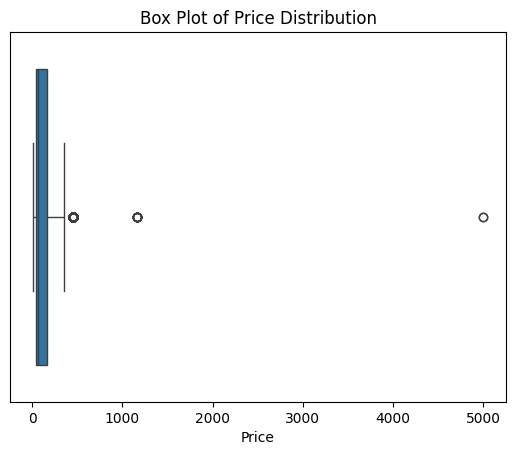

In [19]:
# Create a box plot to visualize the distribution of `price`
sns.boxplot(x=df_data["price"])
plt.title("Box Plot of Price Distribution")
plt.xlabel("Price")
plt.tick_params("y", length=0)
plt.show()

- The box plot indicates the presence of outliers in the price data.
- Let's check the distribution of the price using 10 bins.

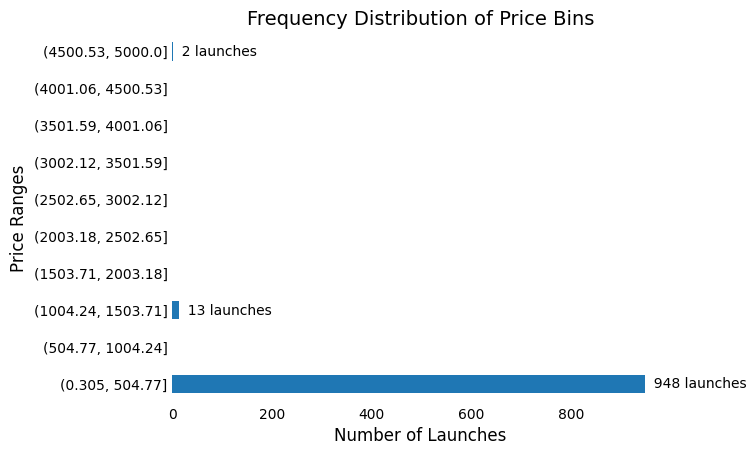

In [20]:
# Create price bins and calculate frequency distribution
price_bins = pd.cut(df_data["price"], bins=10)
frequency_distribution = price_bins.value_counts().sort_index()

# Plot the frequency distribution as a horizontal bar chart
frequency_distribution.plot(kind="barh")
ax = plt.gca()
ax.bar_label(ax.containers[0], frequency_distribution.map(lambda x: "" if x==0 else f"  {x} launches"))

# Customize the appearance of the plot
for spine in ax.spines.values():
    spine.set_visible(False) # Hide the plot spines

ax.tick_params("both", length=0) # Hide tick marks

# Add titles and labels for clarity
ax.set_title("Frequency Distribution of Price Bins", fontsize=14)
ax.set_xlabel("Number of Launches", fontsize=12)
ax.set_ylabel("Price Ranges", fontsize=12)

plt.show()

# Number of Launches per Company

Create a chart that shows the number of space mission launches by organisation.

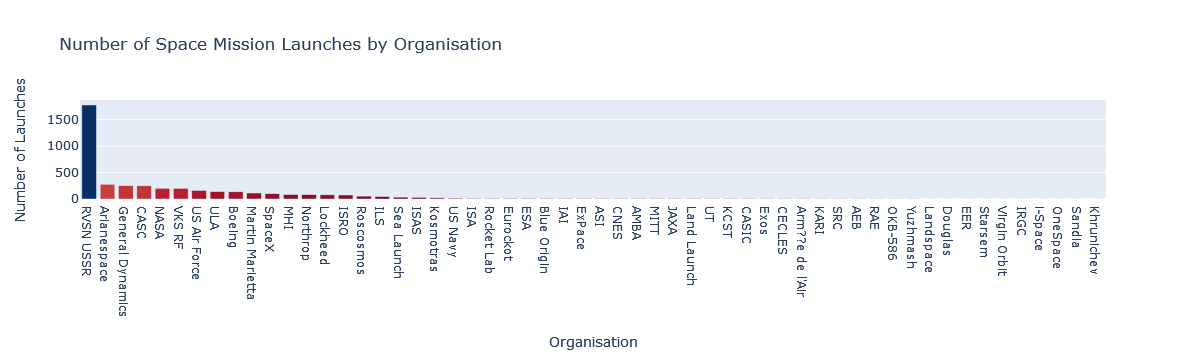

In [21]:
# Count the number of launches per organization
organisations = df_data["organisation"].value_counts().reset_index()
organisations.columns = ["organisation", "count"] # Rename columns for clarity

# Select organisations that launched at least 10 missions.
# organisations = organisations[organisations["count"] >= 10]

# Create a bar plot to visualize the number of launches
fig = go.Figure(go.Bar(
    x=organisations["organisation"],
    y=organisations["count"],
    marker=dict(color=organisations["count"], colorscale="RdBu") # Color by launch count
))

# Set figure parameters for better visualization
fig.update_layout(
    title="Number of Space Mission Launches by Organisation",
    xaxis_title="Organisation",
    yaxis_title="Number of Launches",
    hovermode="x" # Enable hover mode for better interaction
)

fig.show()

- The dataset shows that the Soviet Union has the most launches. 
- Keep in mind that U.S. launch data cannot be solely obtained from NASA, as the U.S. has multiple organizations involved in space missions, unlike the Soviet Union, which had only one organization.

# Number of Active versus Retired Rockets

How many rockets are active compared to those that are decomissioned? 

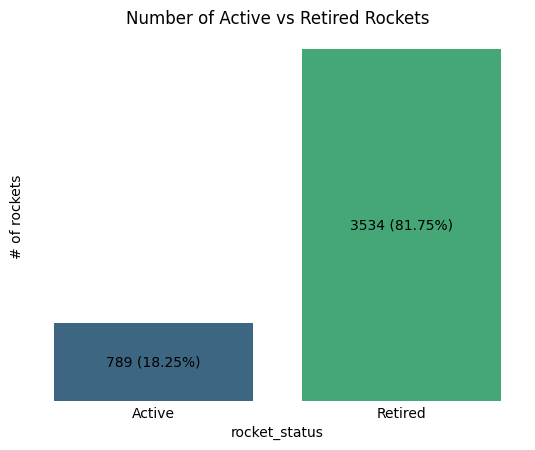

In [22]:
# Count the number of rockets by their status (active vs retired)
rocket_status = df_data.rocket_status.value_counts().sort_index()

# Create a bar plot to visualize the comparison
ax = sns.barplot(rocket_status, palette="viridis")

# Add labels for each bar showing the count and percentage
for i, value in enumerate(rocket_status.values):
    ax.bar_label(ax.containers[i], [f"{value} ({value/rocket_status.sum():.2%})"], label_type="center")

# Set plot labels and title
ax.set_ylabel("# of rockets")
ax.set_title("Number of Active vs Retired Rockets")

for spine in ax.spines.values():
    spine.set_visible(False) # Hide plot spines
ax.tick_params("both", length=0) # Hide tick marks
ax.set_yticks([], [])  # Hide y-axis ticks

plt.show()

- Approximately **82\%** of launched rockets have been retired.
- Most missions were retired by the time this data was collected in **2020**.

# Distribution of Mission Status

How many missions were successful?
How many missions failed?

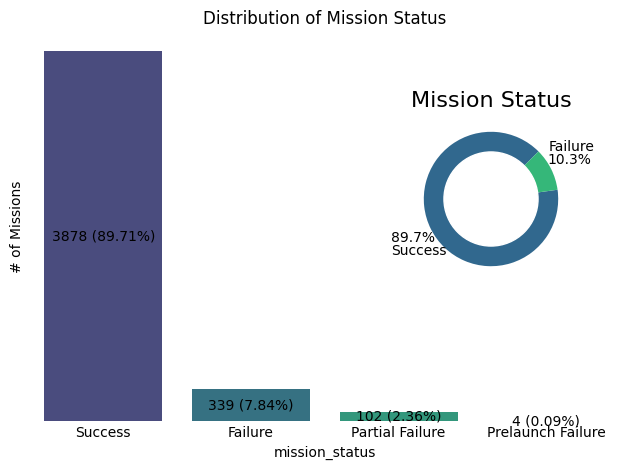

In [23]:
# Count the number of missions by status (successful vs failed)
mission_status = df_data.mission_status.value_counts()

fig = plt.figure()
ax = plt.subplot()

# Create a bar plot to visualize the distribution of mission status
sns.barplot(mission_status, palette="viridis",  ax= ax)

# Add labels for each bar showing the count and percentage
for i, value in enumerate(mission_status.values):
    ax.bar_label(ax.containers[i], [f"{value} ({value/mission_status.sum():.2%})"], label_type="center")

# Set plot labels and title
ax.set_ylabel("# of Missions")
ax.set_title("Distribution of Mission Status")
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params("both", length=0)
ax.set_yticks([], [])

# Create a donut chart in the top right corner
donut_ax = fig.add_axes([0.6, 0.4, 0.35, 0.35])  # [x, y, width, height]
donut_data = df_data.mission_status_binary.value_counts()
donut_ax.pie(donut_data.values, 
             labels=donut_data.index, 
             autopct='%1.1f%%', 
             startangle=45, 
             pctdistance=1.3,
             colors=sns.color_palette("viridis", len(donut_data))
            )

# Adjust label positions for better visibility
pct_1=donut_ax.get_children()[2].get_position()
donut_ax.get_children()[1].set_position((pct_1[0]+.5, pct_1[1]-.2))
pct_2=donut_ax.get_children()[5].get_position()
donut_ax.get_children()[4].set_position((pct_2[0]-.3, pct_2[1]+.2))

# Create the hole for the donut effect
donut_ax.add_artist(plt.Circle((0, 0), 0.7, color='white'))  
donut_ax.set_title("Mission Status", fontsize=16)

plt.tight_layout()
plt.show()

- The vast majority of missions were successful.
- Approximately **10%** of missions resulted in failure or partial failure.
- Only **4 missions** failed before launch.

# How Expensive are the Launches? 

Create a histogram and visualise the distribution. The price column is given in USD millions (careful of missing values). 

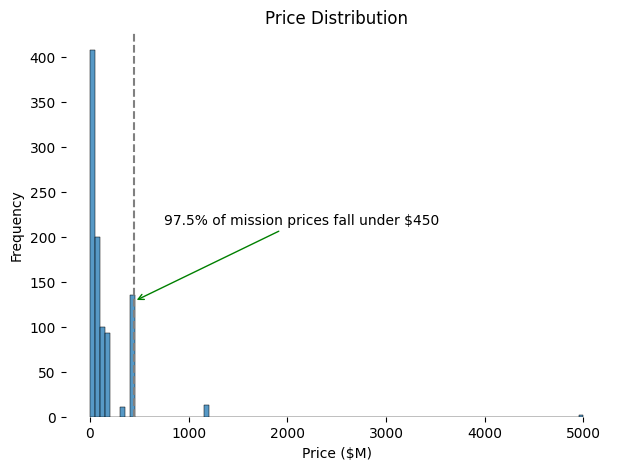

In [24]:
# Set the quantile to 0.975 (97.5th percentile)
quantile =.975

# Compute the 97.5th quantile value for the price column
quantile90 = int(df_data["price"].quantile(quantile))

# Create a new figure for the histogram
fig = plt.figure(figsize=(7,5))
# Plot the histogram of launch prices with 100 bins
ax = sns.histplot(df_data["price"], bins=100, palette="viridis")

# Get the y-axis limits for positioning the annotation
y_lim = ax.get_ylim()
# Add a vertical dashed line at the quantile value
ax.axvline(quantile90, linestyle="--", color="gray")
# Annotate the quantile on the plot
ax.annotate(
    text=f"{quantile:.1%} of mission prices fall under ${quantile90}",
    xy=(quantile90, y_lim[1] * 0.3),
    xytext=(quantile90 + 300, y_lim[1] * 0.5),
    arrowprops=dict(arrowstyle="->", color="green")
)

# Hide the spines of the plot for a cleaner look
[spine.set_visible(False) for spine in ax.spines.values()]

# Set the title and labels for the axes
ax.set_title("Price Distribution")
ax.set_xlabel("Price ($M)")
ax.set_ylabel("Frequency") 

plt.show()

- The price distribution ranges from approximately **\\$5.3 million** to **\\$5,000 million**. However, when narrowing the focus to include **97.5%** of prices, the maximum is limited to **\\$450 million**.


# Use a Choropleth Map to Show the Number of Launches by Country

* Create a choropleth map using [the plotly documentation](https://plotly.com/python/choropleth-maps/)
* Experiment with [plotly's available colours](https://plotly.com/python/builtin-colorscales/). I quite like the sequential colour `matter` on this map. 
* You'll need to extract a `country` feature as well as change the country names that no longer exist.

Wrangle the Country Names

You'll need to use a 3 letter country code for each country. You might have to change some country names.

* Russia is the Russian Federation
* New Mexico should be USA
* Yellow Sea refers to China
* Shahrud Missile Test Site should be Iran
* Pacific Missile Range Facility should be USA
* Barents Sea should be Russian Federation
* Gran Canaria should be USA


You can use the iso3166 package to convert the country names to Alpha3 format.

In [25]:
# Define a mapping for country names that need to be changed
country_map = {"Russia": "Russian Federation", 
               "New Mexico": "USA", 
               "Yellow Sea": "China", 
               "Shahrud Missile Test Site": "Iran, Islamic Republic of", 
               "Iran": "Iran, Islamic Republic of", 
               "Pacific Missile Range Facility": "USA", 
               "Barents Sea": "Russian Federation", 
               "Gran Canaria": "USA",
               "North Korea":"Korea, Democratic People's Republic of", 
               "South Korea": "Korea, Republic of",
               "Pacific Ocean":"Kiribati"}

# Extract country from the location column and map to corrected names
df_data["country"] = df_data.location.str.split(", ").str[-1].map(lambda x: country_map.get(x, x))
df_data["country"].unique()

array(['USA', 'China', 'Kazakhstan', 'Japan', 'Israel', 'New Zealand',
       'Russian Federation', 'Iran, Islamic Republic of', 'France',
       'India', "Korea, Democratic People's Republic of", 'Kiribati',
       'Korea, Republic of', 'Brazil', 'Kenya', 'Australia'], dtype=object)

In [26]:
# Map country names to their 3-letter ISO codes
df_data = df_data.assign(code = df_data["country"].map(lambda c: countries[c].alpha3))
# Group data by country and count launches
df = df_data.groupby(["country", "code"])["code"].value_counts().rename("launches").reset_index()

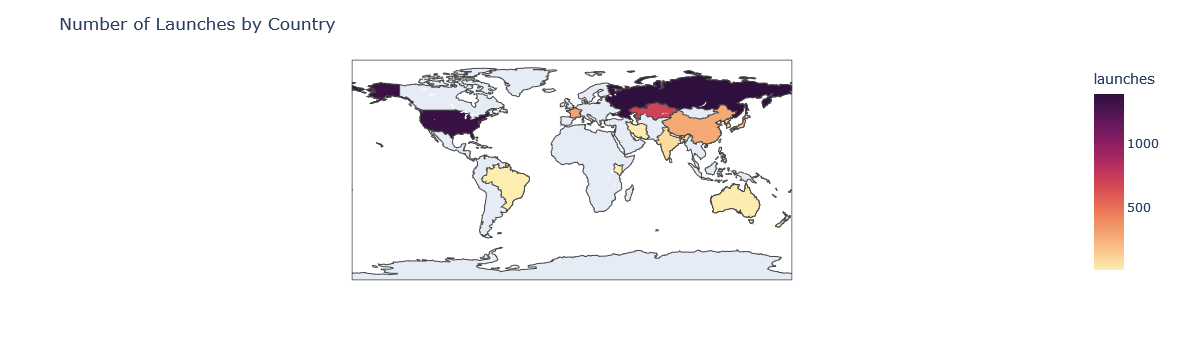

In [27]:
# Create a choropleth map to visualize launches by country
fig = px.choropleth(df, locations="code",
                    color="launches",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.matter)
fig.update_layout(title="Number of Launches by Country")
fig.show()

- The map indicates that the USA and the Russian Federation dominate the launch landscape, with 1,351 and 1,398 launches, respectively.

# Use a Choropleth Map to Show the Number of Failures by Country


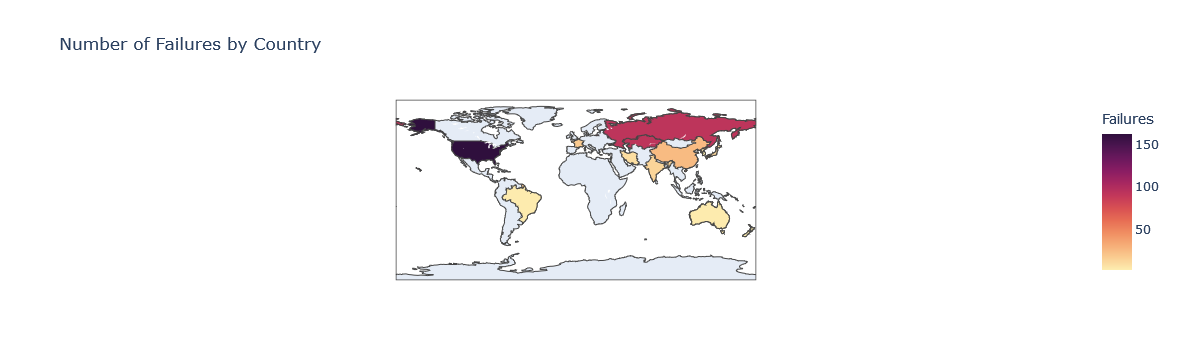

In [28]:
# Group the data by country and code, counting the number of failures
data = df_data.groupby(["country", "code"]).mission_status_binary.value_counts().rename("Failures").reset_index()

# Calculate proportions of failures by country and code
proportions = df_data.groupby(["country", "code"]).mission_status_binary.value_counts(normalize=True).round(3).rename("Proportion").reset_index()

# Merge failures and proportions dataframes
data = data.merge(proportions, how="inner", on=["country", "code", "mission_status_binary"])

# Filter for only failure data
data=data[data.mission_status_binary == "Failure"]

# Create a choropleth map to visualize failures by country
fig = px.choropleth(data, locations="code",
                    color="Failures",
                    hover_data="Proportion",
                    hover_name="country",
                    color_continuous_scale=px.colors.sequential.matter,
                    title="Number of Failures by Country")
fig.show()

- The USA has the highest number of total failures, followed by the Russian Federation and Kazakhstan.
- This can be attributed to their large number of attempted launches.
- In contrast, the Republic of Korea and New Zealand have the lowest number of failures.
- When considering failure as a proportion of total launches, Brazil ranks first in total loss, 
  followed by the Republic of Korea and the Islamic Republic of Iran.
- France has the lowest proportion of failures, followed by the Russian Federation.

# Create a Plotly Sunburst Chart of the countries, organisations, and mission status. 

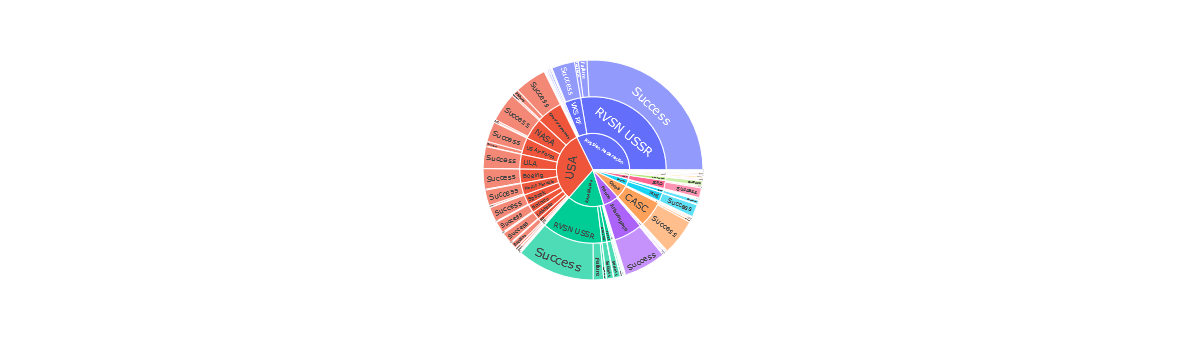

In [29]:
# Group the data by country, organisation, and mission status, counting the occurrences
df_sunburst = df_data.groupby(["country", "organisation"])["mission_status"].value_counts().reset_index()

# Create a Sunburst chart
fig = px.sunburst(
    df_sunburst,
    path=["country", "organisation", "mission_status"], # Define the hierarchy
    values="count" # Use the count as values for the chart
)
fig.show()

# Analyse the Total Amount of Money Spent by Organisation on Space Missions

In [30]:
def expenditure_by_organisation_plot(aggfunc, xlabel, ylabel, title):
    """
    Plots the total expenditure by organization on space missions.

    Parameters:
    aggfunc (function): Aggregation function (e.g., sum, mean).
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    title (str): Title of the plot.

    Returns:
    fig, ax: Matplotlib figure and axes objects.
    """
    # Aggregate the amount of money spent by each organization on space missions
    price = df_data.dropna().groupby("organisation")["price"].agg(aggfunc).reset_index().sort_values("price", ascending=False)
    
    # Create a bar plot
    fig = plt.figure(figsize=(7,6))
    ax = sns.barplot(data=price, y="organisation", x="price", palette="viridis")
    
    # Add labels to the bars indicating the amount spent
    for i, value in enumerate(price["price"].values):
        ax.bar_label(ax.containers[i], [f"${value:.0f}M"])
    [spine.set_visible(False) for spine in ax.spines.values()]
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    return fig, ax

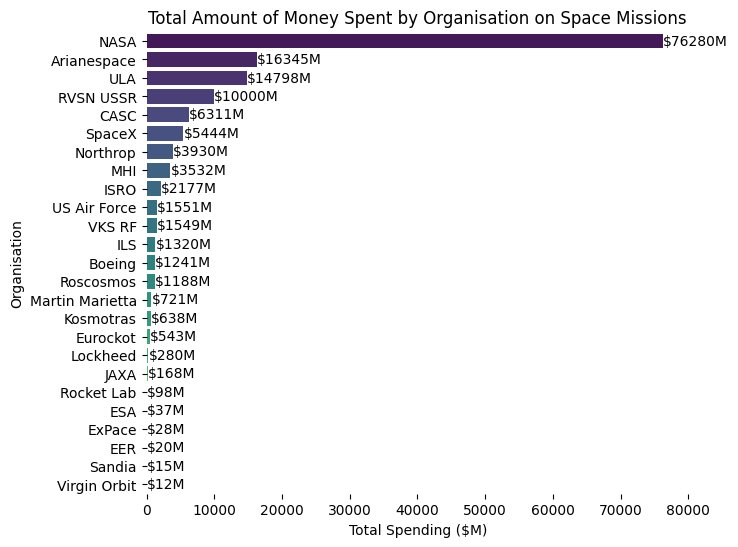

In [31]:
fig, ax = expenditure_by_organisation_plot("sum", 
                                           "Total Spending ($M)", 
                                           "Organisation", 
                                           "Total Amount of Money Spent by Organisation on Space Missions")
plt.show()

- NASA has spent \\$76 billion, with expenditures surpassing the next organization by \\$60 billion.

# Analyse the Amount of Money Spent by Organisation per Launch

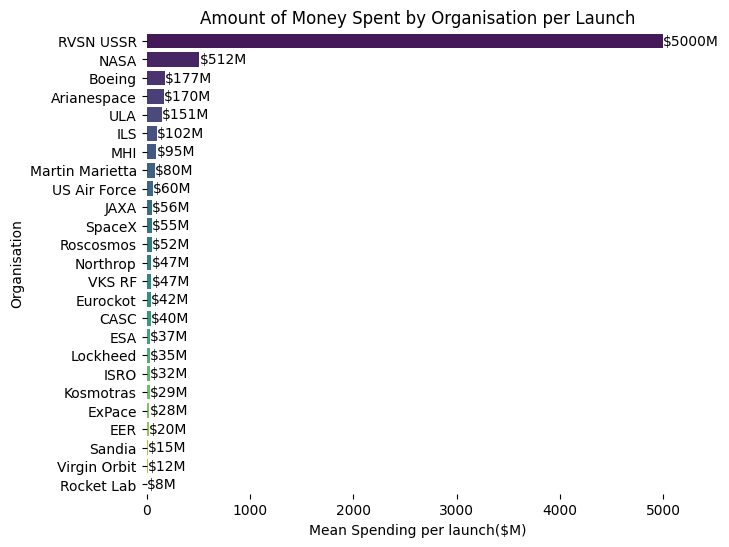

In [32]:
fig, ax = expenditure_by_organisation_plot("mean", 
                                           "Mean Spending per launch($M)", 
                                           "Organisation", 
                                           "Amount of Money Spent by Organisation per Launch")
plt.show()

- The mean cost per launch for RVSN (USSR) is significantly higher than that of other organizations, primarily due to a large number of missing price values. The two available values, which are $5,000 million each, heavily influence this average.

In [33]:
df_data[df_data.organisation == "RVSN USSR"].dropna()[["year", "organisation", "detail", "price"]].reset_index(drop=True)

year organisation                                  detail    price
0  1988    RVSN USSR                  Energiya/Buran | Buran 5,000.00
1  1987    RVSN USSR  Energiya/Polyus | Polyus Space Station 5,000.00

- NASA ranks second with an average spending of $511 million.

# Chart the Number of Launches per Year

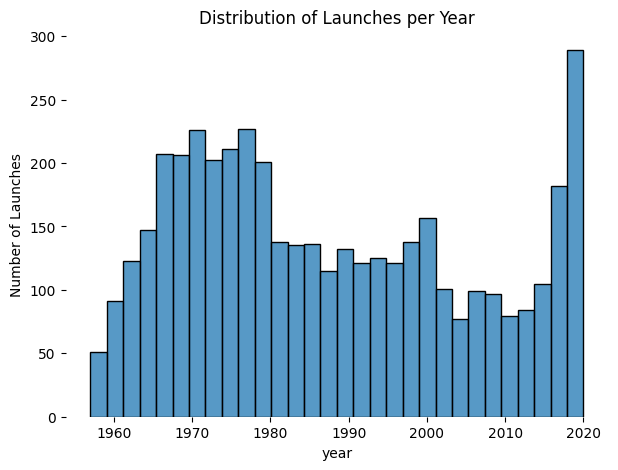

In [34]:
# Extract the year from the 'year' column and create a histogram of launches per year
values = df_data["year"].dt.year
fig = plt.figure(figsize=(7,5))
# Plot the distribution of launches using a histogram
ax=sns.histplot(values, bins=30, palette="viridis")
plt.ylabel("Number of Launches")
plt.title("Distribution of Launches per Year")

for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()

- There was a momentum of launches that began in the late 1960s, peaked in the 1970s, and then started to decline thereafter.
- However, there has been an increase in launches in recent years.

# Chart the Number of Launches Month-on-Month until the Present

Which month has seen the highest number of launches in all time? Superimpose a rolling average on the month on month time series chart. 

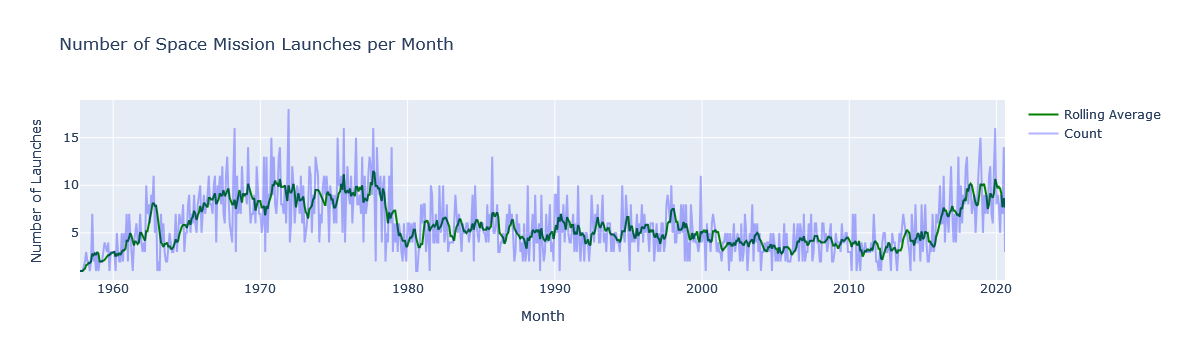

In [35]:
# Count the number of launches per month and sort by month index
data = df_data["month"].value_counts().sort_index()

# Calculate a rolling average over a 6-month window
data_rolling_average = data.rolling(window=6, min_periods=1).mean()

# Convert month indices to strings for plotting
x = data.index.astype(str)
y = data_rolling_average.values

# Add a trace for the rolling average
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x, 
    y=y, 
    line=dict(color="green"), 
    name="Rolling Average"
))

# Add a trace for the monthly launch counts
fig.add_trace(go.Scatter(
    x=x, 
    y=data.values, 
    line=dict(color="rgba(0, 0, 255, 0.3)"), 
    name="Count"
))
fig.update_layout(
    title="Number of Space Mission Launches per Month",
    xaxis_title="Month",
    yaxis_title="Number of Launches",
    hovermode="x"
)
fig.show()


In [36]:
# Identify the month with the highest number of launches
month_max = data.idxmax()
print("Month with the highest number of launches in all time:")
print(f"    - {month_max}: {data[month_max]} launches")

Month with the highest number of launches in all time:
    - 1971-12: 18 launches


- December 1971 recorded the highest number of launches, with a total of 18 launches.

# Launches per Month: Which months are most popular and least popular for launches?

Some months have better weather than others. Which time of year seems to be best for space missions?

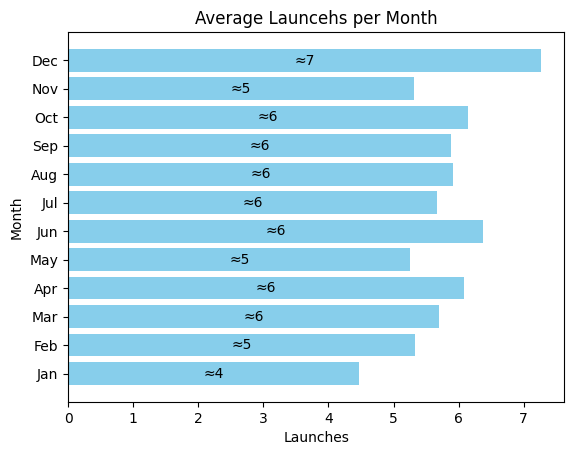

In [37]:
# Count launches per month and reset the index
data = df_data["month"].value_counts().reset_index()
data.columns = ["month", "count"]

# Extract month number and calculate average counts
data["month"] = data["month"].dt.month
data = data.groupby("month")["count"].mean()
data.sort_index(inplace=True)

# Convert month indices to abbreviations e.g. Jan, Feb
data.index = [calendar.month_abbr[x] for x in data.index]

# Create a horizontal bar plot for average launches per month
plt.barh(data.index, data.values, color="skyblue")
ax=plt.gca()
# Add labels to the bars
ax.bar_label(ax.containers[0], data.map(lambda x: f"≈{round(x)}"), label_type="center")
ax.set_title("Average Launcehs per Month")
ax.set_xlabel("Launches")
ax.set_ylabel("Month")
plt.show()

- December is the most popular month for space missions, while January is the least popular. 
- Based on the average number of launched rockets per month, December is the best month for space missions, and January is the worst.

# How has the Launch Price varied Over Time? 

Create a line chart that shows the average price of rocket launches over time. 

In [38]:
def quantile025(col):
    """Calculate the 2.5th percentile of a column."""
    return col.quantile(.025)

def quantile975(col):
    """Calculate the 97.5th percentile of a column."""
    return col.quantile(.975)

# Calculate the quantiles for each month
quantiles = df_data.groupby("month")["price"].agg([quantile025, quantile975]).reset_index()

# Merge quantiles back into the original dataframe
filtered_data = df_data.merge(quantiles, left_on="month", right_on="month", how="inner")

# Filter out outliers based on quantiles
filtered_data = filtered_data[
    (filtered_data.price <= filtered_data.quantile975) & 
    (filtered_data.price >= filtered_data.quantile025)
]

# Group by year and calculate the average price of launches
data = filtered_data.groupby("year")["price"].mean()

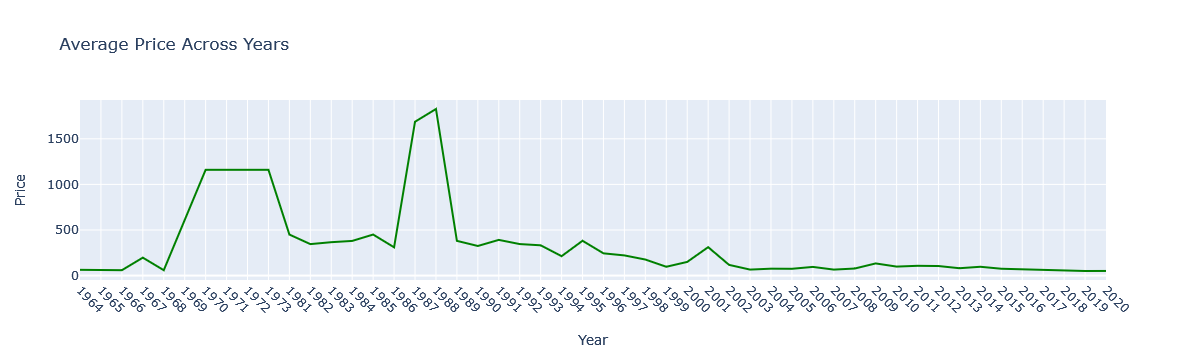

In [39]:
# Create the line chart
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=data.index.astype(str), 
    y=data, 
    mode='lines',
    line=dict(color="green")
))

# Update x-axis tick angle for better readability
fig.update_xaxes(tickangle=45)

# Set layout titles
fig.update_layout(
    title="Average Price Across Years", 
    xaxis_title="Year", 
    yaxis_title="Price", 
    showlegend=False
)
fig.show()



### Analysis of Price Trends After Outlier Removal Within Each Year:

1. **Data Gaps (1957-1964 & 1973-1981):**  
   Notable gaps in the data during these periods indicate a lack of recorded launch price information, which could affect trend analysis.

2. **Price Spike in 1987 and 1988:**  
   A significant increase in launch prices during these years suggests an anomaly or a shift in market dynamics, possibly due to geopolitical or economic factors.

3. **Fluctuations and Declining Trend Post-1980s:**  
   The data shows fluctuations in launch prices after the 1980s, alongside an overall declining trend, indicating potential instability in the market.

4. **Stable Decline (2010-2020):**  
   The last decade exhibits a more consistent decline in prices, suggesting increased efficiency and competition in the launch market, leading to lower costs.

# Chart the Number of Launches over Time by the Top 10 Organisations. 

How has the dominance of launches changed over time between the different players? 

In [40]:
top_ten_orgs = df_data.organisation.value_counts()[:10].index.tolist()
top_ten_launches_vs_year = df_data[df_data["organisation"].isin(top_ten_orgs)].groupby("organisation").year.value_counts().unstack().T
print("Top ten organisations: ", 
      *map(lambda x: f"    {f'{x[1]}'.rjust(2,'0')}- {x[0]} ({(df_data['organisation']==x[0]).sum()})",
           zip(top_ten_orgs, range(1,11))), 
      sep="\n")

Top ten organisations: 
    01- RVSN USSR (1777)
    02- Arianespace (279)
    03- General Dynamics (251)
    04- CASC (250)
    05- NASA (203)
    06- VKS RF (201)
    07- US Air Force (161)
    08- ULA (140)
    09- Boeing (136)
    10- Martin Marietta (114)


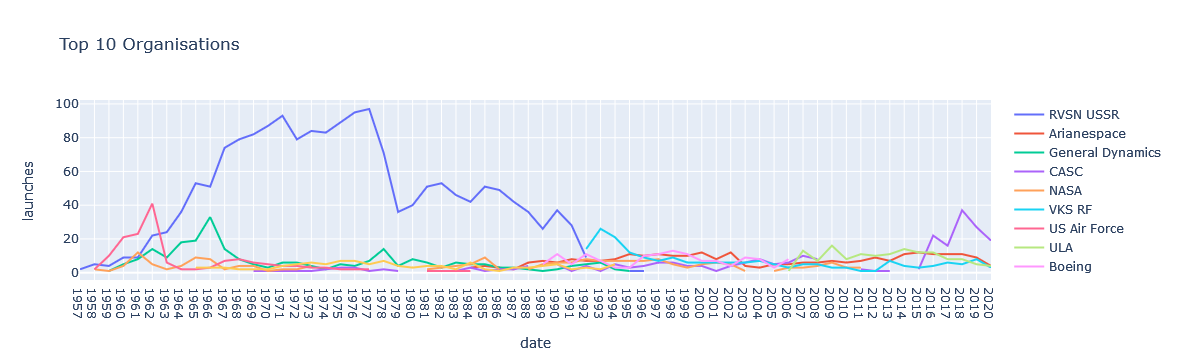

In [41]:
fig = go.Figure()
for organisation in top_ten_orgs:
    fig.add_trace(
        go.Scatter(x=top_ten_launches_vs_year.index.astype(str), y=top_ten_launches_vs_year[organisation], name=organisation
        )
    )

fig.update_layout(xaxis_title="date", 
                 yaxis_title="launches",
                 title="Top 10 Organisations",
                 hovermode="x")
fig.show()

1. **Dominance in Launch Counts by RVSN USSR (1965-1990):**  
    - There was a strong dominance in launch counts from 1965 to 1990, with a notable decline in 1979 for the RVSN USSR organization.

2. **Early Dominance of the US Air Force:**  
   The US Air Force was a key player in the early stages of space exploration, establishing its dominance during this formative period.

3. **CASC's Recent Leadership:**  
   In recent years, particularly over the last five, the China Aerospace Science and Technology Corporation (CASC) has emerged as a leading organization in space exploration among the top ten entities.

# Cold War Space Race: USA vs USSR

The cold war lasted from the start of the dataset up until 1991. 

In [42]:
countries_sorted = sorted(df_data.country.unique())
print("Countries:", 
      *map(lambda x: f"    {str(x[1]).rjust(2, '0')}- {' '.join(x[0].split(', ')[::-1])}", zip(countries_sorted, range(1, len(countries_sorted) + 1))),
      sep="\n")

Countries:
    01- Australia
    02- Brazil
    03- China
    04- France
    05- India
    06- Islamic Republic of Iran
    07- Israel
    08- Japan
    09- Kazakhstan
    10- Kenya
    11- Kiribati
    12- Democratic People's Republic of Korea
    13- Republic of Korea
    14- New Zealand
    15- Russian Federation
    16- USA


- **Soviet Union During the Cold War:**  
    - Both the Russian Federation and Kazakhstan were integral parts of the Soviet Union during the Cold War era.

In [43]:
# Define the countries of interest for the Cold War analysis
us_an_russia = ["Kazakhstan", "USA", "Russian Federation"]

# Filter the dataset for launches during the Cold War (up to 1991)
cold_war = df_data[(df_data.date.dt.year <= 1991) & (df_data.country.isin(us_an_russia))]

# Standardize country names: change 'Russian Federation' and 'Kazakhstan' to 'USSR'
cold_war["country"][cold_war["country"].isin(["Russian Federation", "Kazakhstan"])] = "USSR"

## Create a Plotly Pie Chart comparing the total number of launches of the USSR and the USA

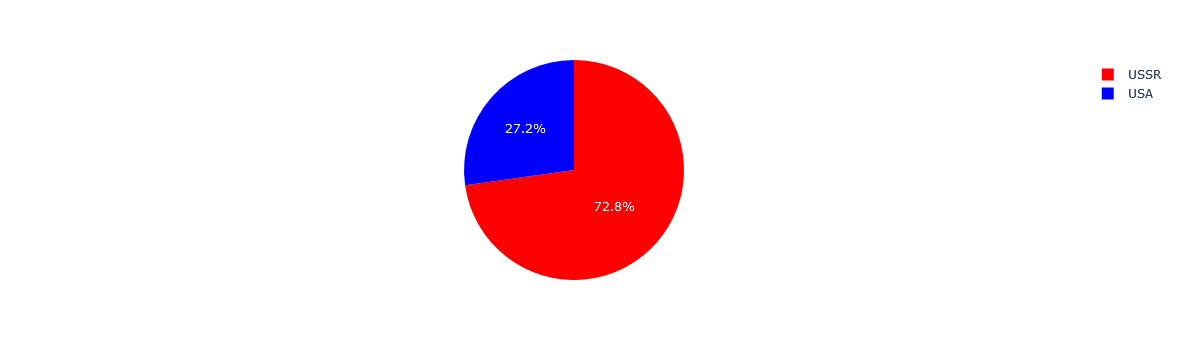

In [44]:
# Count the number of launches by each country
data = cold_war.country.value_counts().rename("launches").reset_index()

fig = px.pie(data, values="launches", names="country", color="country", 
             color_discrete_map = {"USSR": "red", "USA":"blue"})
fig.show()

- **Soviet Union vs. USA Launches:**  
  During this era, the number of launches by the USSR was approximately three times that of the USA.

## Create a Chart that Shows the Total Number of Launches Year-On-Year by the Two Superpowers

In [45]:
def comparison_line(df, title):
    """
    Generates a line chart comparing the total number of launches by different countries.

    Parameters:
    df (DataFrame): DataFrame containing launch counts indexed by year.
    title (str): Title of the chart.
    """
    fig = go.Figure()
    for col in df.columns:
        fig.add_trace(go.Scatter(x=df.index.astype(str), y=df[col], name=col))
    
    fig.update_layout(xaxis_title="Year", yaxis_title="Failures Percentage", hovermode="x", title=title)
    return fig

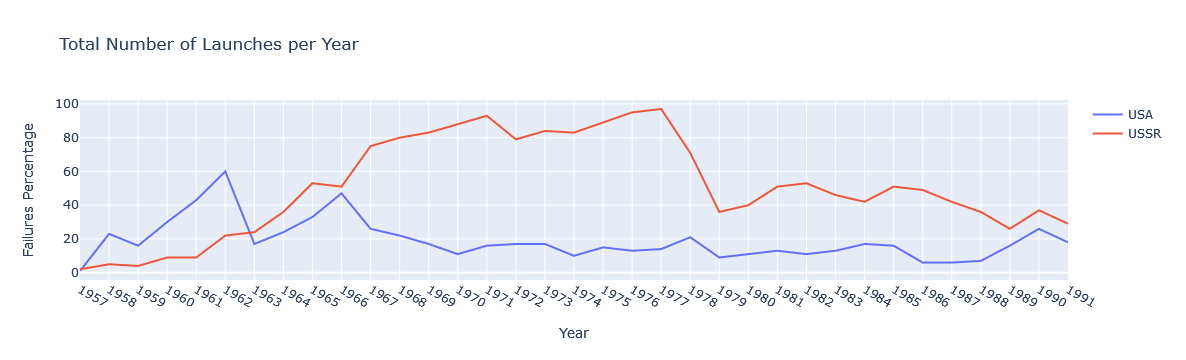

In [46]:
# Group data by year and country to get total launches per year
yearly_launches = cold_war.groupby("year")["country"].value_counts().unstack()

fig = comparison_line(yearly_launches, "Total Number of Launches per Year")
fig.show()

- The race peaked in 1966, with each country contributing around 50 launches. The USSR then maintained a significant lead in launches until 1979, when the difference began to narrow.  
- From 1970, the USA demonstrated consistency in its launch numbers, reaching a peak in 1990.

## Chart the Total Number of Mission Failures Year on Year.

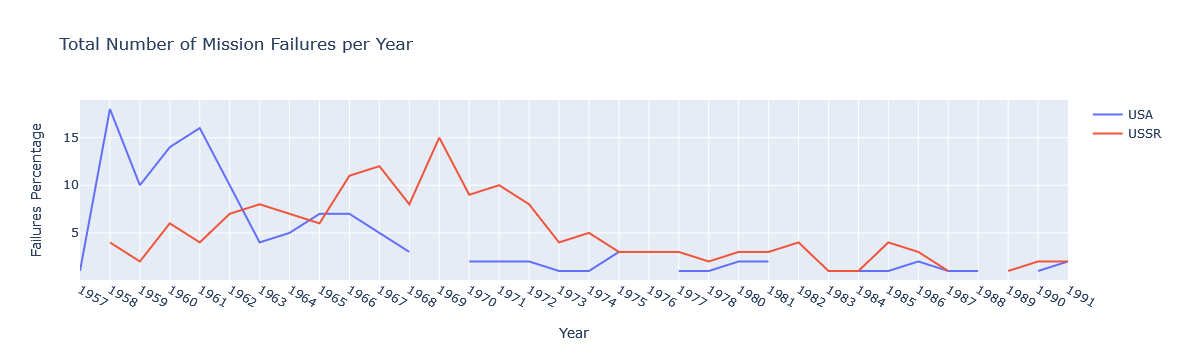

In [47]:
# Group data by year and country to get total failures per year
yearly_failures = cold_war[cold_war["mission_status_binary"]=="Failure"]\
.groupby("year")["country"].value_counts().unstack()

fig = comparison_line(yearly_failures, "Total Number of Mission Failures per Year")
fig.show()

## Chart the Percentage of Failures over Time

Did failures go up or down over time? Did the countries get better at minimising risk and improving their chances of success over time? 

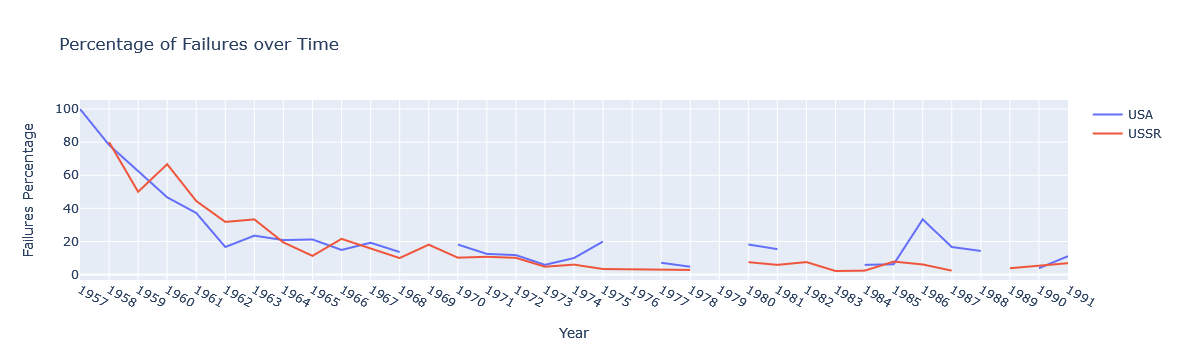

In [48]:
# Calculate the percentage of failures by dividing yearly failures by yearly launches
yearly_failures_percent = yearly_failures / yearly_launches * 100

fig = comparison_line(yearly_failures_percent, "Percentage of Failures over Time")
fig.show()

- The plot here shows that the percentage of failures decreased over time, indicating improvements in reliability and success rates in launches.

# For Every Year Show which Country was in the Lead in terms of Total Number of Launches up to and including including 2020)

Do the results change if we only look at the number of successful launches? 

In [49]:
def bar_plot(df, title):
    # Adjust country names for pre-1991 data
    df["country"].loc[df["year"].dt.year < 1991] = "USSR"
    
    # Find the leading country for each year based on total launches
    launches_leader = df.merge(df.groupby("year")["count"].max().reset_index(), how="inner", 
                                     left_on=["year", "count"],
                                     right_on=["year", "count"]).sort_values("year")
    
    # Extract year
    launches_leader["year"] = launches_leader.year.dt.year
    fig = px.bar(launches_leader, x="year", y="count", color="country")
    fig.update_layout(xaxis_title="Year", yaxis_title="Launches", title=title, hovermode="x")
    return fig

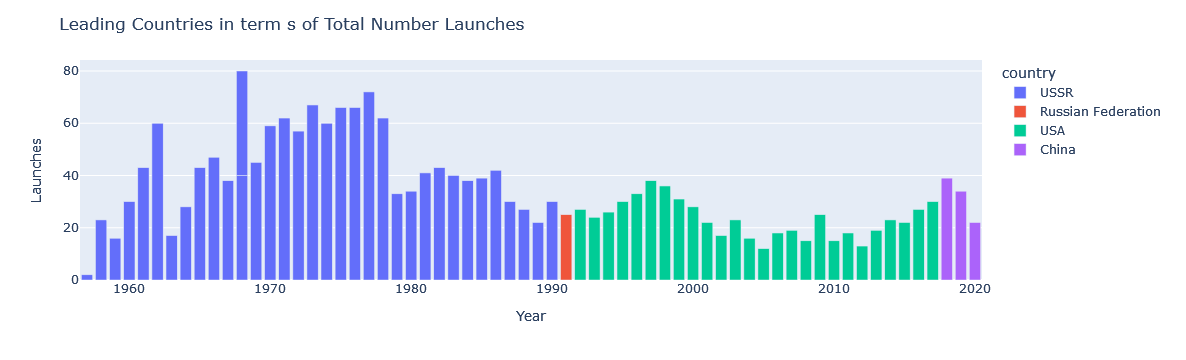

In [50]:
# Count total launches by year and country
launches = df_data[["year", "country"]].value_counts().reset_index()
title="Leading Countries in term s of Total Number Launches"

fig = bar_plot(launches, title)
fig.show()

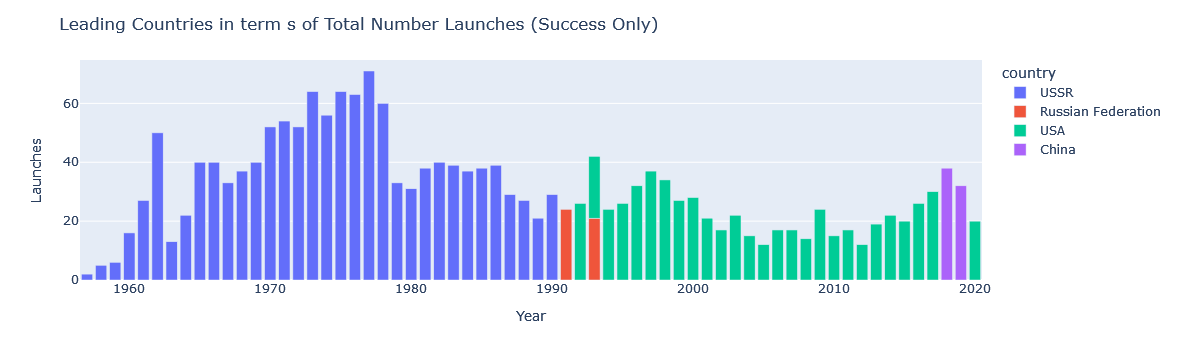

In [51]:
# Count successful launches by year and country
launches = df_data[df_data["mission_status_binary"]=="Success"][["year", "country"]].value_counts().reset_index()
title="Leading Countries in term s of Total Number Launches (Success Only)"

fig = bar_plot(launches, title)
fig.show()

- During the Cold War, the Soviet Union dominated in total launches. After this period, the USA took the lead until 2017, when China began to emerge as the leading country in total launches.
- If we consider only successful launches, China led in 2018 and 2019, while the USA led in 1992. Additionally, there was a tie between the Russian Federation and the USA in 1993. In all other years, the dominance remained consistent with the previous trends.

# Create a Year-on-Year Chart Showing the Organisation Doing the Most Number of Launches

Which organisation was dominant in the 1970s and 1980s? Which organisation was dominant in 2018, 2019 and 2020? 

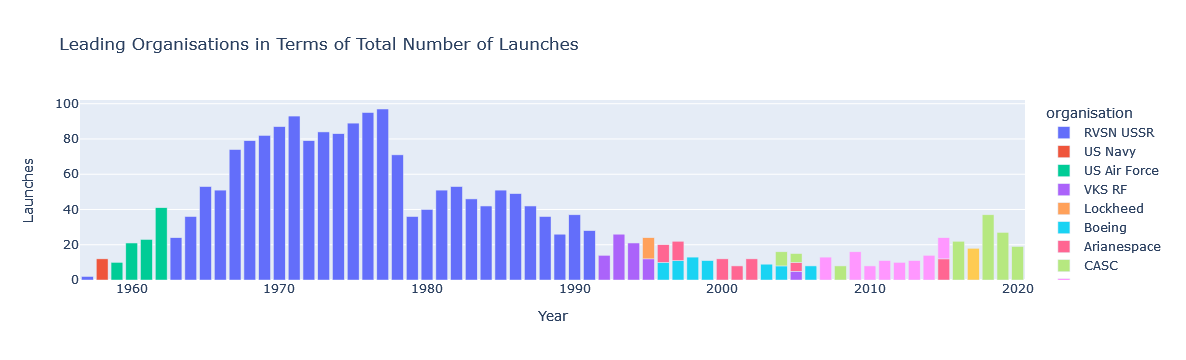

In [52]:
launches = df_data[["year", "organisation"]].value_counts().reset_index(name='count')
launches_leader = launches.merge(
    launches.groupby("year")["count"].max().reset_index(),
    how="inner",
    left_on=["year", "count"],
    right_on=["year", "count"]
).sort_values("year")
launches_leader["year"] = launches_leader.year.dt.year

fig = px.bar(
    launches_leader,
    x="year",
    y="count",
    color="organisation",
    title="Leading Organisations in Terms of Total Number of Launches"
)
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Launches",
    hovermode="x"
)
fig.show()


- The RVSN (Rocket Forces of the Strategic Missile Troops) of the USSR dominated during the 1970s and 1980s. In contrast, the China National Space Administration (CASC) emerged as a dominant force from 2018 to 2020.